In [80]:
from optimization_func import simulated_annealing
from helper import mse, mae, r2, lotka_volterra, int_cost_lotka_volterra, get_predator_prey_data
t, P = get_predator_prey_data()
import shelve
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats


In [81]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [82]:
def F_test(Samples_A, Samples_B):
    """ Calculates the F-test based on the data from two datasets.
        Returns:
            F-statistics (int)
            p=value (int)
    """
    A_var,  A_len = np.var(Samples_A, ddof = 1), len(Samples_A)
    B_var, B_len = np.var(Samples_B, ddof = 1), len(Samples_B)
    F = max(A_var/B_var, B_var/A_var)
    if A_var > B_var:
        n1 = A_len
        n2 = B_len
    else: 
        n2 = A_len
        n1 = B_len
    p_value = 1 - scipy.stats.f.cdf(F, (n1 - 1), (n2 - 1))
    return F, p_value

In [83]:
def Convergence_data(rvs, cost, n_sim=100, eta = 0.2):
    Dict = {}
    for rv in rvs:
        sim_data = []
        r2s = []
        for n in range(n_sim):
            state, _, _, costs = simulated_annealing(rv, t, P, cost=cost, cooling_schedule="quadratic", T_start=200, T_steps=2000, write_costs = True, eta = eta)
            sim_data.append(costs)
            r2_value = int_cost_lotka_volterra(state, P, t, cost=r2)
            r2s.append(r2_value)
        Dict[str(rv)] = (sim_data, r2s)
    
    return Dict               

In [84]:
xs_chosen = [[0.66593614, 2.94213991, 8.129154  , 4.88824876], #10
    [1.59035578, 3.964897  , 8.93986609, 2.72514184], #9
    [2.91245287, 2.70612094, 2.01560385, 1.47317489], # good guess (MSE ~ 3.4)
  ]

In [85]:
%%time
np.random.seed(567567)
if False: 
    shelf = shelve.open("Arrays/MSE_vs_MAE")
    Test_mse = Convergence_data(rvs=xs, cost=mse)
    shelf["Test_mse"] = Test_mse
    Test_mae = Convergence_data(rvs=xs, cost=mae)
    shelf["Test_mae"] = Test_mae
    shelf.close() 

Wall time: 0 ns


In [86]:
shelf = shelve.open("Arrays/MSE_vs_MAE")
Test_mse = shelf["Test_mse"] 
Test_mae = shelf["Test_mae"] 
shelf.close() 

In [106]:
def Convergence_plotter(rvs, Test_mse, Test_mae, T_steps=2000):
    iterations = range(1,T_steps + 2)
    Cost = ["MSE", "MAE"]
    i = 0
    for data in  [Test_mse, Test_mae]:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        j = 0
        for rv in rvs:
            results = data[str(rv)][0]
            mean = np.mean(results, axis = 0)
            r2_mean = np.mean(data[str(rv)][1], axis = 0)
            a = [sp_confidence_interval(samples) for samples in np.array(results).T]
            #plt.hlines(y=mean[-1]*1.1, xmin=0, xmax=T_steps, linestyles='--', color = colors[j], linewidth = 1)
            plt.plot(iterations, mean, colors[j], linewidth = 1)
            plt.fill_between(iterations, mean - a, mean + a, alpha = 0.2, color = colors[j])
            j += 1
            
        plt.grid(alpha=0.3)
        plt.ylabel(Cost[i])
        i +=1
        plt.xlabel("Iteration")
        #plt.yscale("log")
        plt.show()  


C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


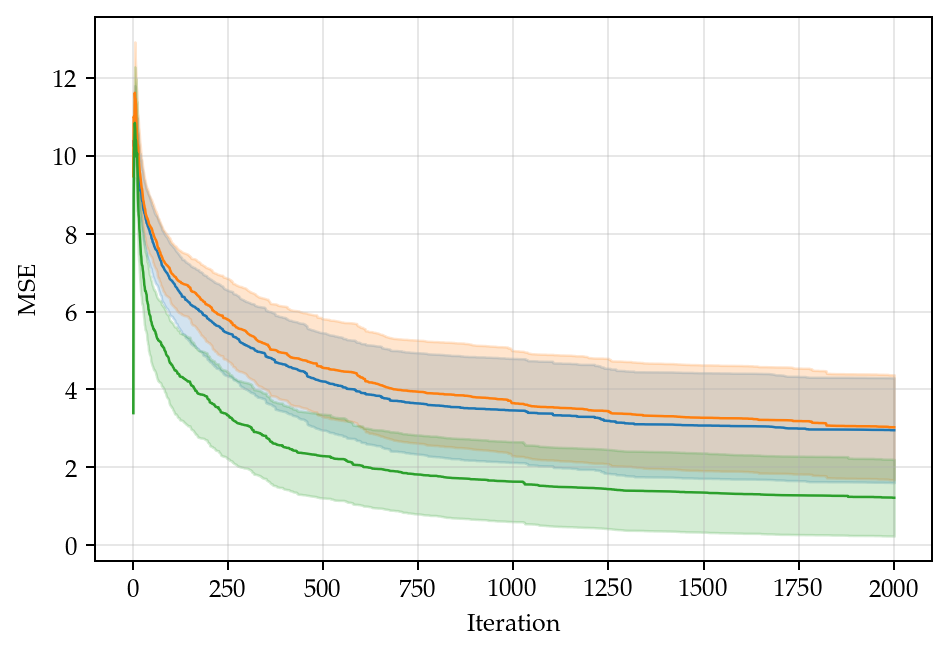

C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


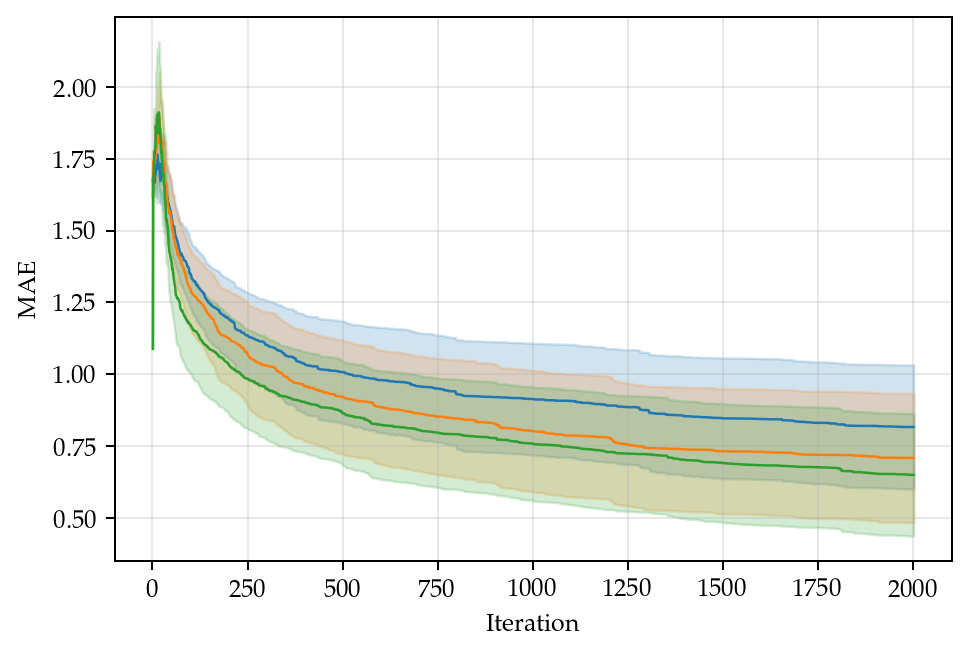

In [107]:
Convergence_plotter(xs_chosen, Test_mse, Test_mae, T_steps=2000)

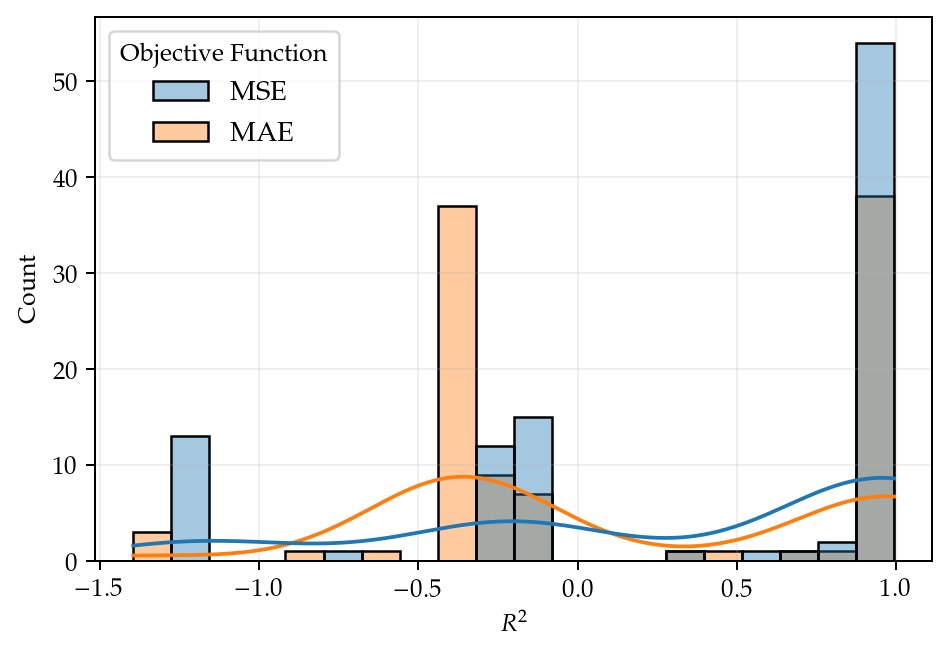

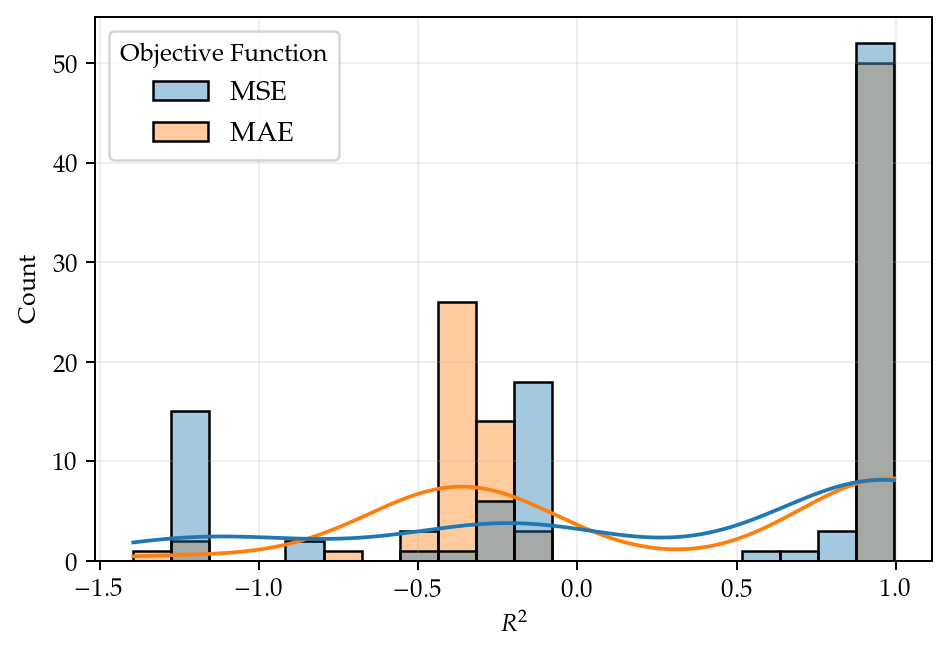

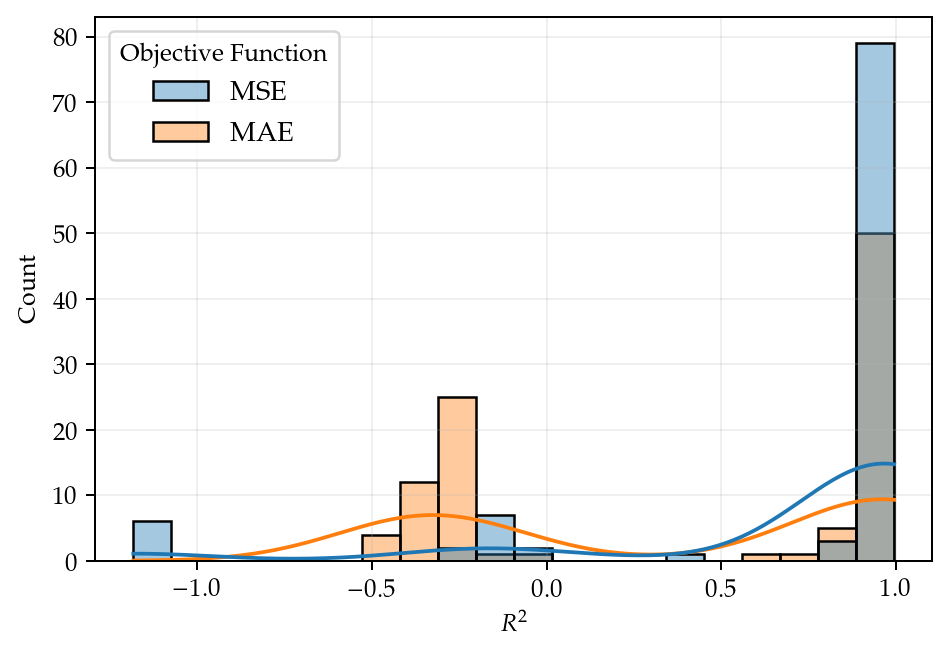

In [103]:
import pandas as pd 
for rv in xs_chosen: 
    MSE_r2 = Test_mse[str(rv)][1]
    MAE_r2 = Test_mae[str(rv)][1]
    MSE_r2 = np.array([np.repeat("MSE", len(MSE_r2)), MSE_r2])
    MAE_r2 = np.array([np.repeat("MAE", len(MAE_r2)), MAE_r2])
    Data = np.concatenate([MSE_r2, MAE_r2], axis = 1)

    #create a pandas dataframe
    df = pd.DataFrame(Data.T, columns = ["Objective Function", "$R^2$"])
    df = df.astype({"$R^2$" : float})
    plt.grid(alpha = 0.2)
    sns.histplot(data = df, hue="Objective Function", x="$R^2$", alpha=0.4, kde = True, bins = 20)
    plt.show()

In [102]:
import seaborn as sns
import scipy 

i = 1
for rv in xs_chosen:
    print("\n")        
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print("For rv", i)
    print("Starting R2:", int_cost_lotka_volterra(rv, P, t, cost=r2))
    j = 0
    Cost = ["MSE", "MAE"]
    for data in [Test_mse, Test_mae]:
        print("\n")
        print(Cost[j])
        results = data[str(rv)][1]
        print("Mean", np.mean(results, axis = 0))
        print("Median", np.median(results, axis = 0))
        print("best", np.max(results, axis = 0))
        print("worst", np.min(results, axis = 0))
        j +=1
        

    print("\nStatistical Tests:")
    _, p1 = F_test(Test_mse[str(rv)][1], Test_mae[str(rv)][1])
    if p1*3 > 0.05: 
        print("p-value F-test:", p1*3)
        print("No statistical difference variance")
    _, p2 = scipy.stats.ttest_ind(Test_mse[str(rv)][1], Test_mae[str(rv)][1], equal_var = True)
    if p2*3 > 0.05: 
        print("p-value t-test", p2*3)
        print("No statistical difference mean")
    else: 
        print("p-value t-test", p2*3)
        print("statistical difference mean")
    i += 1



xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
For rv 1
Starting R2: -1.2971372933606249


MSE
Mean 0.3387681772822533
Median 0.9302307804383041
best 0.9922162434829324
worst -1.1826533273214754


MAE
Mean 0.1545225166610628
Median -0.274274512691679
best 0.9940934571530038
worst -1.3944406159521585

Statistical Tests:
p-value F-test: 0.4061237243140585
No statistical difference variance
p-value t-test 0.24895502813611187
No statistical difference mean


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
For rv 2
Starting R2: -1.2390177286702897


MSE
Mean 0.29428892078222796
Median 0.9130653147361673
best 0.9936060877371939
worst -1.1826477220482425


MAE
Mean 0.28084898862003416
Median 0.4022328401821931
best 0.994084400356047
worst -1.3940888895912904

Statistical Tests:
p-value F-test: 0.29080071348087466
No statistical difference variance
p-value t-test 2.7074158212293638
No statistical difference mean


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
For rv 3
Starting R2: 0.015527518784367755


MSE
Mean 0.